# LSTM Stock Price Prediction Model

## Overview
This notebook implements a Long Short-Term Memory (LSTM) neural network for stock price prediction using **5 key features** that are easy to understand and explain to stakeholders.

## The 5 Key Features

Instead of using only the closing price, our model uses 5 intuitive features:

1. **Close Price** - The actual stock closing price (our main target)
   - What it means: The final price at market close each day
   - Why it matters: Historical prices show trends and patterns

2. **Volume** - Number of shares traded
   - What it means: How many shares were bought/sold that day
   - Why it matters: High volume indicates strong interest/conviction in price moves

3. **20-Day Moving Average (MA20)** - Average price over last 20 days
   - What it means: Smoothed trend line showing general direction
   - Why it matters: Helps identify if stock is trending up or down

4. **Volatility** - How much the price fluctuates
   - What it means: Standard deviation of daily returns over 20 days
   - Why it matters: High volatility = risky/unpredictable, Low volatility = stable

5. **RSI (Relative Strength Index)** - Momentum indicator (0-100)
   - What it means: Measures if stock is overbought (>70) or oversold (<30)
   - Why it matters: Helps predict potential reversals in price direction

## Model Architecture

**Simplified LSTM Design:**
- **2 LSTM Layers** with 64 hidden units each
- **Bidirectional processing** - looks at patterns from both past and future
- **Dropout (20%)** - prevents overfitting to training data
- **Output layer** - predicts next day's closing price

**How it works:**
1. Takes the last 60 days of these 5 features as input
2. LSTM layers learn patterns in the sequential data
3. Outputs a prediction for the next day's closing price

## Why These 5 Features?

- **Price (Close)**: The fundamental data - what we're predicting
- **Volume**: Confirms whether price moves are strong or weak
- **MA20**: Shows the overall trend without daily noise
- **Volatility**: Captures risk and uncertainty in the market
- **RSI**: Identifies potential turning points (reversals)

These 5 features together give the model information about:
- **Trend** (MA20)
- **Momentum** (RSI)
- **Risk** (Volatility)
- **Conviction** (Volume)
- **Price History** (Close)

## Usage
1. Select a stock ticker (default: 'A')
2. Run all cells in order
3. Model trains automatically and shows results
4. Review visualizations to understand predictions

## Important Notes
- **Educational purposes only** - Not financial advice
- **Past performance does not equal future results**
- Model shows what patterns exist in historical data
- Real markets affected by news, earnings, global events not captured here

## Key Parameters
- `n_past = 60`: Uses last 60 days to predict next day
- `hidden_size = 64`: LSTM memory capacity
- `num_layers = 2`: Two LSTM layers
- `dropout = 0.2`: 20% dropout for regularization
- `batch_size = 32`: Training batch size
- `num_epochs = 50`: Training iterations


In [1]:
# Step 0: Import Libraries

import os
import math
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
plt.style.use("seaborn-v0_8")


In [2]:
# enable GPU is running the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
# Helper Functions for Feature Engineering and Sequence Creation

def calculate_features(df):
    """
    Calculate the 5 key features for stock prediction:
    1. Close - closing price
    2. Volume - trading volume
    3. MA20 - 20-day moving average
    4. Volatility - 20-day standard deviation of returns
    5. RSI - Relative Strength Index (14-day)
    """
    df = df.copy()
    
    # Feature 1: Close price (already in dataset)
    # Feature 2: Volume (already in dataset)
    
    # Feature 3: 20-day Moving Average
    df["MA20"] = df["Close"].rolling(window=20).mean()
    
    # Feature 4: Volatility (standard deviation of daily returns)
    df["Daily_Return"] = df["Close"].pct_change()
    df["Volatility"] = df["Daily_Return"].rolling(window=20).std()
    
    # Feature 5: RSI (Relative Strength Index, 14-day)
    delta = df["Close"].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df["RSI"] = 100 - (100 / (1 + rs))
    
    # Drop the intermediate Daily_Return column (not needed as feature)
    df = df.drop("Daily_Return", axis=1)
    
    return df


def create_sequences_multivariate(data, feature_cols, target_col, n_past):
    """
    Create sequences for multivariate LSTM
    
    Args:
        data: DataFrame with all features (scaled where appropriate)
        feature_cols: list of column names to use as features
        target_col: name of target column to predict
        n_past: number of past time steps to use as input
    
    Returns:
        X: (num_samples, n_past, num_features)
        y: (num_samples,)
    """
    X, y = [], []
    
    feature_data = data[feature_cols].values
    target_data = data[target_col].values
    
    for i in range(n_past, len(data)):
        X.append(feature_data[i - n_past:i])
        y.append(target_data[i])
    
    return np.array(X), np.array(y)


def smooth(series, window=5):
    """Simple moving average smoother for nicer plots (visual only)."""
    return pd.Series(series).rolling(window, min_periods=1).mean().values


In [4]:
# Paths relative to notebook location
DATA_ROOT = "../../data/archive"
META_PATH = os.path.join(DATA_ROOT, "symbols_valid_meta.csv")

meta_df = pd.read_csv(META_PATH)

print("Meta columns:", meta_df.columns.tolist())
print("Total symbols in meta:", len(meta_df))

# === Choose a ticker to model ===
# Example: "A", "AAAU", "AAPL", etc.
target_ticker = "A"

row = meta_df[meta_df["Symbol"] == target_ticker]
if row.empty:
    raise ValueError(f"Symbol {target_ticker} not found in metadata.")

is_etf = (row["ETF"].iloc[0] == "Y")
asset_type = "etfs" if is_etf else "stocks"

print(f"Selected symbol: {target_ticker} | ETF? {is_etf} | Folder: {asset_type}")


Meta columns: ['Nasdaq Traded', 'Symbol', 'Security Name', 'Listing Exchange', 'Market Category', 'ETF', 'Round Lot Size', 'Test Issue', 'Financial Status', 'CQS Symbol', 'NASDAQ Symbol', 'NextShares']
Total symbols in meta: 8049
Selected symbol: A | ETF? False | Folder: stocks


In [5]:
#Load data of selected ticker
data_path = os.path.join(DATA_ROOT, asset_type, f"{target_ticker}.csv")
stock_df = pd.read_csv(data_path)
stock_df.head()



,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.068665,62546300.0
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.838577,15234100.0
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.068665,6577800.0
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.607880,5975600.0
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.261524,4843200.0


In [6]:
# Ensure we have a Date column
if "Date" not in stock_df.columns:
    if "date" in stock_df.columns:
        stock_df = stock_df.rename(columns={"date": "Date"})
    else:
        raise KeyError("No 'Date' or 'date' column found in CSV.")

# Ensure we have a Close column
if "Close" not in stock_df.columns:
    if "Adj Close" in stock_df.columns:
        stock_df = stock_df.rename(columns={"Adj Close": "Close"})
    elif "close" in stock_df.columns:
        stock_df = stock_df.rename(columns={"close": "Close"})
    else:
        raise KeyError("No 'Close', 'Adj Close', or 'close' column found in CSV.")

# Ensure we have Volume (if missing, we can fill with 0s)
if "Volume" not in stock_df.columns:
    if "volume" in stock_df.columns:
        stock_df = stock_df.rename(columns={"volume": "Volume"})
    else:
        # Fallback: create a dummy volume column if truly missing
        stock_df["Volume"] = 0.0

stock_df["Date"] = pd.to_datetime(stock_df["Date"])
stock_df = stock_df.sort_values("Date").reset_index(drop=True)

print("Full date range:", stock_df["Date"].min().date(), "→", stock_df["Date"].max().date())

# Restrict to a project window (adjust as needed)
start_date = datetime(2014, 1, 1)
end_date   = stock_df["Date"].max()

mask = (stock_df["Date"] >= start_date) & (stock_df["Date"] <= end_date)
stock_df = stock_df.loc[mask].reset_index(drop=True)

print(f"Rows for {target_ticker} from {start_date.date()} to {end_date.date()}:",
      len(stock_df))

stock_df[["Date", "Close", "Volume"]].head()


Full date range: 1999-11-18 → 2025-12-01
Rows for A from 2014-01-01 to 2025-12-01: 2997


,Date,Close,Volume
0,2014-01-02,40.207439,2678800.0
1,2014-01-03,40.715309,2609600.0
2,2014-01-06,40.515022,2484600.0
3,2014-01-07,41.094421,2045500.0
4,2014-01-08,41.766811,3717900.0


In [7]:
# 1) Compute technical features
stock_df_fe = calculate_features(stock_df.copy())

# 2) Compute log-return (next-day target)
#    r_t = log(C_t / C_{t-1})
stock_df_fe["log_return"] = np.log(
    stock_df_fe["Close"] / stock_df_fe["Close"].shift(1)
)

# 3) Drop NaNs from rolling windows and first return
stock_df_fe = stock_df_fe.dropna().reset_index(drop=True)

print("Data after feature engineering:")
print(stock_df_fe[["Date", "Close", "Volume", "MA20", "Volatility", "RSI", "log_return"]].head())


# 4) Define features + target
feature_columns = ["Close", "Volume", "MA20", "Volatility", "RSI"]
target_column = "log_return"

# Keep full series for later reconstruction
full_dates = stock_df_fe["Date"].values
full_closes = stock_df_fe["Close"].values
T = len(stock_df_fe)

print("Total usable rows after dropping NaNs:", T)

# 5) Chronological train/test split
train_size = int(T * 0.8)
train_df = stock_df_fe.iloc[:train_size].reset_index(drop=True)
test_df  = stock_df_fe.iloc[train_size:].reset_index(drop=True)

print(f"Train rows: {len(train_df)}, Test rows: {len(test_df)}")

# 6) Scale features ONLY (not the target)
feature_scaler = MinMaxScaler()
train_features = feature_scaler.fit_transform(train_df[feature_columns])
test_features  = feature_scaler.transform(test_df[feature_columns])

train_df_scaled = train_df.copy()
test_df_scaled  = test_df.copy()
train_df_scaled[feature_columns] = train_features
test_df_scaled[feature_columns]  = test_features

# 7) Create sequences
n_past = 60  # lookback window

X_train, y_train = create_sequences_multivariate(
    train_df_scaled, feature_columns, target_column, n_past
)
X_test, y_test = create_sequences_multivariate(
    test_df_scaled, feature_columns, target_column, n_past
)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)


    # 'Close',      # Feature 1: Historical closing prices
    # 'Volume',     # Feature 2: Trading volume
    # 'MA20',       # Feature 3: 20-day moving average (trend)
    # 'Volatility', # Feature 4: Price volatility (risk)
    # 'RSI'         # Feature 5: Relative Strength Index (momentum)


Data after feature engineering:
        Date      Close     Volume       MA20  Volatility        RSI  \
0 2014-01-31  41.595135  4804200.0  42.129113    0.014517  45.833317   
1 2014-02-03  40.164520  4095100.0  42.101574    0.016361  37.764066   
2 2014-02-04  41.351933  4070800.0  42.143419    0.017643  41.425016   
3 2014-02-05  41.080116  3192800.0  42.142704    0.017442  37.864889   
4 2014-02-06  41.695278  2250000.0  42.139128    0.017377  41.292348   

   log_return  
0   -0.023119  
1   -0.034999  
2    0.029135  
3   -0.006595  
4    0.014864  
Total usable rows after dropping NaNs: 2977
Train rows: 2381, Test rows: 596
X_train: (2321, 60, 5) y_train: (2321,)
X_test: (536, 60, 5) y_test: (536,)


In [8]:
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()

X_test_tensor  = torch.from_numpy(X_test).float()
y_test_tensor  = torch.from_numpy(y_test).float()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset  = TensorDataset(X_test_tensor,  y_test_tensor)

batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, drop_last=False)


In [9]:
# Simplified LSTM Model

class StockLSTM(nn.Module):
    """
    Simple LSTM model for stock prediction

    Architecture:
    - 2 Bidirectional LSTM layers (looks at patterns from past and future)
    - 64 hidden units per layer
    - 20% dropout to prevent overfitting
    - Fully connected output layer
    """
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2, bidirectional=True):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )
        
        lstm_output_size = hidden_size * (2 if bidirectional else 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(lstm_output_size, 1)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        batch_size = x.size(0)
        num_directions = 2 if self.bidirectional else 1
        
        h0 = torch.zeros(self.num_layers * num_directions, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * num_directions, batch_size, self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))  # out: (batch, seq_len, hidden * directions)
        
        # Take the last time step
        last_hidden = out[:, -1, :]      # (batch, hidden * directions)
        last_hidden = self.dropout(last_hidden)
        
        out = self.fc(last_hidden)       # (batch, 1)
        return out.squeeze(-1)           # (batch,)



In [10]:
# Training and Evaluation Functions

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * X_batch.size(0)
    
    return running_loss / len(dataloader.dataset)


def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            running_loss += loss.item() * X_batch.size(0)
            
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())
    
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    
    return running_loss / len(dataloader.dataset), all_targets, all_preds



In [11]:
# Model initialization
num_features = X_train.shape[2]

model = StockLSTM(
    input_size=num_features,
    hidden_size=64,
    num_layers=2,
    dropout=0.2,
    bidirectional=True
).to(device)

criterion = nn.MSELoss()  # still MSE, but now on returns
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

num_epochs = 50

print(model)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Training loop with best-model saving
best_test_loss = float("inf")
best_model_path = f"best_lstm_{target_ticker}_returns.pth"
train_losses, test_losses = [], []

for epoch in range(1, num_epochs + 1):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    test_loss, _, _ = evaluate_model(model, test_loader, criterion, device)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    
    scheduler.step(test_loss)
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), best_model_path)
    
    if epoch == 1 or epoch % 5 == 0:
        print(f"Epoch {epoch:03d} | Train Loss (returns): {train_loss:.6f} | Test Loss (returns): {test_loss:.6f}")

print(f"\nBest test loss (returns): {best_test_loss:.6f}")
print(f"Best model saved to: {best_model_path}")


StockLSTM(
  (lstm): LSTM(5, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)
Total parameters: 135,809
Epoch 001 | Train Loss (returns): 0.000393 | Test Loss (returns): 0.000346
Epoch 005 | Train Loss (returns): 0.000289 | Test Loss (returns): 0.000347
Epoch 010 | Train Loss (returns): 0.000278 | Test Loss (returns): 0.000347
Epoch 015 | Train Loss (returns): 0.000277 | Test Loss (returns): 0.000346
Epoch 020 | Train Loss (returns): 0.000274 | Test Loss (returns): 0.000346
Epoch 025 | Train Loss (returns): 0.000274 | Test Loss (returns): 0.000348
Epoch 030 | Train Loss (returns): 0.000274 | Test Loss (returns): 0.000347
Epoch 035 | Train Loss (returns): 0.000273 | Test Loss (returns): 0.000346
Epoch 040 | Train Loss (returns): 0.000273 | Test Loss (returns): 0.000346
Epoch 045 | Train Loss (returns): 0.000272 | Test Loss (returns): 0.000347
Epoch 050 | Train Loss

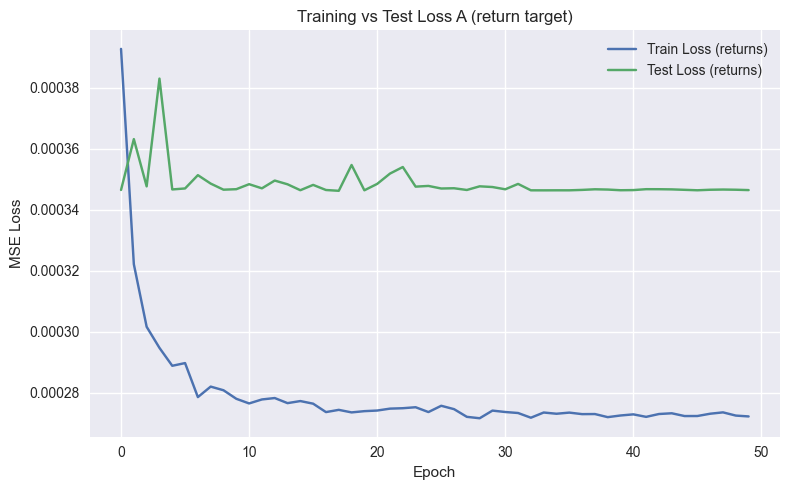

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss (returns)")
plt.plot(test_losses, label="Test Loss (returns)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Training vs Test Loss {target_ticker} (return target)")
plt.legend()
plt.tight_layout()
plt.show()


Train loss (MSE, returns): 0.000271
Test  loss (MSE, returns): 0.000346

=== Return-space metrics (next-day log-return) ===
Train RMSE: 1.646640e-02
Test  RMSE: 1.860586e-02
Train MAE : 1.175631e-02
Test  MAE : 1.336160e-02
Train MAPE: 54327.094%
Test  MAPE: 105.566%

=== Price-space metrics (using predicted returns → price) ===
Train RMSE (price): 1.5506
Test  RMSE (price): 2.3643


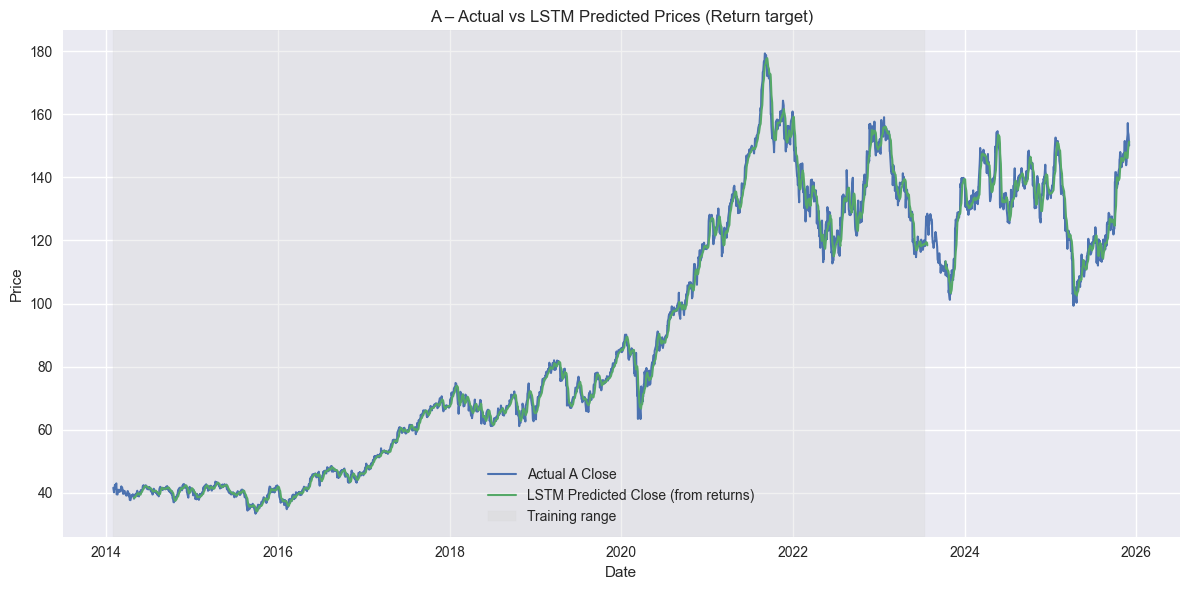

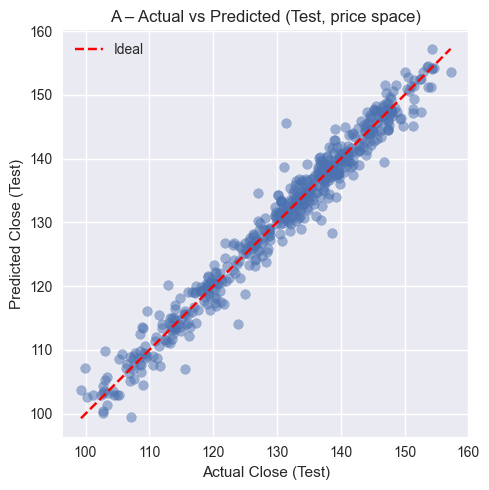

In [13]:
# Load best model
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

# Evaluate in return space
train_loss, y_train_true, y_train_pred = evaluate_model(model, train_loader, criterion, device)
test_loss, y_test_true, y_test_pred = evaluate_model(model, test_loader, criterion, device)

y_train_true = np.array(y_train_true)
y_train_pred = np.array(y_train_pred)
y_test_true  = np.array(y_test_true)
y_test_pred  = np.array(y_test_pred)

print(f"Train loss (MSE, returns): {train_loss:.6f}")
print(f"Test  loss (MSE, returns): {test_loss:.6f}")

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100

# Return-space metrics
train_rmse_ret = math.sqrt(mean_squared_error(y_train_true, y_train_pred))
test_rmse_ret  = math.sqrt(mean_squared_error(y_test_true,  y_test_pred))
train_mae_ret  = np.mean(np.abs(y_train_true - y_train_pred))
test_mae_ret   = np.mean(np.abs(y_test_true  - y_test_pred))
train_mape_ret = mape(y_train_true, y_train_pred)
test_mape_ret  = mape(y_test_true,  y_test_pred)

print("\n=== Return-space metrics (next-day log-return) ===")
print(f"Train RMSE: {train_rmse_ret:.6e}")
print(f"Test  RMSE: {test_rmse_ret:.6e}")
print(f"Train MAE : {train_mae_ret:.6e}")
print(f"Test  MAE : {test_mae_ret:.6e}")
print(f"Train MAPE: {train_mape_ret:.3f}%")
print(f"Test  MAPE: {test_mape_ret:.3f}%")

# Reconstruct predicted prices from predicted returns
full_pred_prices = np.full_like(full_closes, np.nan, dtype=float)

# Train segment reconstruction
len_train = len(train_df)
for j, r_pred in enumerate(y_train_pred):
    i_local = n_past + j
    i_global = i_local  # train_df starts at global index 0
    base_price = full_closes[i_global - 1]
    pred_price = base_price * np.exp(r_pred)
    full_pred_prices[i_global] = pred_price

# Test segment reconstruction
len_test = len(test_df)
for j, r_pred in enumerate(y_test_pred):
    i_local = n_past + j
    i_global = train_size + i_local  # offset by train_size
    if i_global >= T:
        break  # safety
    base_price = full_closes[i_global - 1]
    pred_price = base_price * np.exp(r_pred)
    full_pred_prices[i_global] = pred_price

# Price-space metrics (only where predictions exist)
mask_train = np.zeros_like(full_closes, dtype=bool)
mask_test  = np.zeros_like(full_closes, dtype=bool)

mask_train[n_past:train_size] = ~np.isnan(full_pred_prices[n_past:train_size])
mask_test[train_size + n_past : T] = ~np.isnan(
    full_pred_prices[train_size + n_past : T]
)

train_rmse_price = math.sqrt(
    mean_squared_error(full_closes[mask_train], full_pred_prices[mask_train])
)
test_rmse_price = math.sqrt(
    mean_squared_error(full_closes[mask_test], full_pred_prices[mask_test])
)

print("\n=== Price-space metrics (using predicted returns → price) ===")
print(f"Train RMSE (price): {train_rmse_price:.4f}")
print(f"Test  RMSE (price): {test_rmse_price:.4f}")

# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(full_dates, full_closes, label=f"Actual {target_ticker} Close", linewidth=1.5)

pred_smooth = smooth(full_pred_prices, window=7)
plt.plot(full_dates, pred_smooth, label=f"LSTM Predicted Close (from returns)", linewidth=1.5)

# Shade training region
plt.axvspan(full_dates[0], full_dates[train_size - 1],
            color="lightgrey", alpha=0.3, label="Training range")

plt.title(f"{target_ticker} – Actual vs LSTM Predicted Prices (Return target)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

# Scatter actual vs predicted prices (test region)
plt.figure(figsize=(5, 5))
plt.scatter(full_closes[mask_test], full_pred_prices[mask_test], alpha=0.5)
min_p = min(full_closes[mask_test].min(), full_pred_prices[mask_test].min())
max_p = max(full_closes[mask_test].max(), full_pred_prices[mask_test].max())
plt.plot([min_p, max_p], [min_p, max_p], "r--", label="Ideal")
plt.xlabel("Actual Close (Test)")
plt.ylabel("Predicted Close (Test)")
plt.title(f"{target_ticker} – Actual vs Predicted (Test, price space)")
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
def forecast_future_to_date(
    date_str,
    model,
    feature_scaler,
    feature_columns,
    stock_df,
    n_past,
    device,
    max_horizon_days=60,
):
    """
    Forecast future prices up to a target date that is AFTER the last known date,
    using the trained LSTM (which predicts next-day log-return).

    Assumptions:
    - We use business days (Mon–Fri) via pd.bdate_range.
    - Future Volume is approximated as the last known Volume.
    - MA20, Volatility, RSI are recomputed at each step from simulated closes.
    - Intended for short horizons (<= 30–60 business days).

    Returns:
        future_dates : DatetimeIndex of forecasted days
        future_prices: numpy array of predicted Close prices
    """
    target_date = pd.to_datetime(date_str).normalize()

    # Start from raw history with Date, Close, Volume
    hist_raw = stock_df[["Date", "Close", "Volume"]].copy()
    hist_raw["Date"] = pd.to_datetime(hist_raw["Date"])
    hist_raw = hist_raw.sort_values("Date").reset_index(drop=True)

    # Compute technical indicators on historical data
    hist_fe = calculate_features(hist_raw.copy())
    hist_fe = hist_fe.dropna().reset_index(drop=True)

    last_known_date = hist_fe["Date"].iloc[-1].normalize()

    if target_date <= last_known_date:
        raise ValueError("Target date is not after the last known date. Use in-sample logic instead.")

    # Generate business days between last_known_date+1 and target_date (inclusive)
    future_dates = pd.bdate_range(last_known_date + pd.Timedelta(days=1), target_date)

    if len(future_dates) == 0:
        raise ValueError("No business days between last known date and target date.")

    if len(future_dates) > max_horizon_days:
        raise ValueError(
            f"Forecast horizon too long: {len(future_dates)} business days. "
            f"Max allowed is {max_horizon_days}."
        )

    future_prices = []

    # We will extend hist_fe step-by-step with simulated future rows
    cur_df = hist_fe.copy()

    model.eval()
    with torch.no_grad():
        for fdate in future_dates:
            if len(cur_df) < n_past:
                raise ValueError("Not enough history to build an LSTM window.")

            # Last n_past rows for features
            window = cur_df.iloc[-n_past:].copy()

            # Scale features
            feats = window[feature_columns].values
            feats_scaled = feature_scaler.transform(feats)
            X = torch.from_numpy(feats_scaled.reshape(1, n_past, -1)).float().to(device)

            # Predict next-day log-return
            r_pred = model(X).item()

            # Reconstruct next-day Close
            last_close = window["Close"].iloc[-1]
            new_close = last_close * math.exp(r_pred)

            # Approximate Volume as last known volume
            new_volume = window["Volume"].iloc[-1]

            # Append new raw row
            new_row_raw = {"Date": fdate, "Close": new_close, "Volume": new_volume}
            raw_extended = pd.concat(
                [cur_df[["Date", "Close", "Volume"]], pd.DataFrame([new_row_raw])],
                ignore_index=True,
            )

            # Recompute indicators on the extended raw data
            cur_df = calculate_features(raw_extended)
            cur_df = cur_df.dropna().reset_index(drop=True)

            # Last row now corresponds to fdate
            future_prices.append(new_close)

    return future_dates, np.array(future_prices)


In [15]:
def query_price_and_trend(
    date_str,
    full_dates,
    full_closes,
    full_pred_prices,
    target_ticker,
    model,
    feature_scaler,
    feature_columns,
    stock_df,
    n_past,
    device,
    max_horizon_days=60,
):
    """
    Query actual vs predicted price and predicted trend for a given date.

    Behavior:
    - If date_str is WITHIN the historical dataset:
        -> Use in-sample predicted prices (full_pred_prices).
    - If date_str is AFTER the last known date:
        -> Forecast forward day-by-day using the LSTM (up to max_horizon_days),
           then report the forecasted price and trend.

    Args:
        date_str        : "YYYY-MM-DD"
        full_dates      : numpy array of datetime64 (historical dates)
        full_closes     : numpy array of actual Close prices (historical)
        full_pred_prices: numpy array of in-sample predicted Close prices (NaNs where unavailable)
        target_ticker   : symbol string, e.g. "A"
        model           : trained LSTM model (predicting log-return)
        feature_scaler  : MinMaxScaler fitted on feature_columns
        feature_columns : list of feature names used by the model
        stock_df        : original historical DataFrame (Date, Close, Volume, etc.)
        n_past          : lookback window size
        device          : torch.device
        max_horizon_days: max allowed business-day horizon for future forecasts
    """
    target_date = pd.to_datetime(date_str).normalize()

    first_date = pd.to_datetime(full_dates[0]).normalize()
    last_date  = pd.to_datetime(full_dates[-1]).normalize()

    # ---------- Case 1: date before our dataset ----------
    if target_date < first_date:
        print(f"Date {date_str} is before the first available date "
              f"({first_date.date()}) for {target_ticker}.")
        return

    # ---------- Case 2: date is inside the historical dataset ----------
    if target_date <= last_date:
        target_np = np.datetime64(target_date)
        indices = np.where(full_dates == target_np)[0]

        if len(indices) == 0:
            print(f"Date {date_str} not found in the dataset for {target_ticker}.")
            return

        i = indices[0]
        actual_price = full_closes[i]
        pred_price = full_pred_prices[i]

        print(f"=== {target_ticker} on {date_str} (within dataset) ===")
        print(f"Actual close:    {actual_price:.4f}")

        if np.isnan(pred_price):
            print("No LSTM price prediction available for this date "
                  "(likely within the initial window).")
            return

        print(f"Predicted close: {pred_price:.4f}")

        # Trend vs previous day (predicted)
        if i == 0 or np.isnan(full_pred_prices[i - 1]):
            print("Cannot compute predicted trend: missing previous prediction.")
            return

        prev_pred = full_pred_prices[i - 1]
        if pred_price > prev_pred:
            trend = "UP"
        elif pred_price < prev_pred:
            trend = "DOWN"
        else:
            trend = "FLAT"

        pct_change = (pred_price - prev_pred) / (prev_pred + 1e-8) * 100

        print(f"Predicted trend vs previous day: {trend} "
              f"({prev_pred:.4f} → {pred_price:.4f}, {pct_change:.2f}%)")
        return

    # ---------- Case 3: date is AFTER the historical dataset -> FUTURE FORECAST ----------
    print(f"=== {target_ticker} on {date_str} (future forecast) ===")
    print(f"Last known historical date: {last_date.date()}")

    try:
        future_dates, future_prices = forecast_future_to_date(
            date_str=date_str,
            model=model,
            feature_scaler=feature_scaler,
            feature_columns=feature_columns,
            stock_df=stock_df,
            n_past=n_past,
            device=device,
            max_horizon_days=max_horizon_days,
        )
    except ValueError as e:
        print("Could not forecast:", e)
        return

    # The forecast for the requested date is the last one in the sequence
    forecast_price = future_prices[-1]

    print(f"Forecasted close: {forecast_price:.4f}")

    # Trend vs previous business day
    if len(future_prices) == 1:
        # Only one predicted step; compare vs last actual historical price
        prev_price = full_closes[-1]
        source_label = "last actual historical price"
    else:
        prev_price = future_prices[-2]
        source_label = "previous forecasted business day"

    if forecast_price > prev_price:
        trend = "UP"
    elif forecast_price < prev_price:
        trend = "DOWN"
    else:
        trend = "FLAT"

    pct_change = (forecast_price - prev_price) / (prev_price + 1e-8) * 100

    print(f"Predicted trend vs {source_label}: {trend} "
          f"({prev_price:.4f} → {forecast_price:.4f}, {pct_change:.2f}%)")

    # (Optional) If you want to see the full forecast path, you could also print:
    # for d, p in zip(future_dates, future_prices):
    #     print(d.date(), "→", f"{p:.4f}")


In [ ]:
# Test the Query Function

# print("Testing predictions for different dates:\n")

# # Example 1: Historical date
# query_price_and_trend("2019-06-03", dates_full, actual_prices_full, full_pred, stock_df)

# # Example 2: Another historical date
# query_price_and_trend("2020-03-20", dates_full, actual_prices_full, full_pred, stock_df)

# # Example 3: Recent date in dataset

# query_price_and_trend("2025-10-01", dates_full, actual_prices_full, full_pred, stock_df)

# In-sample
query_price_and_trend(
    "2020-03-20",
    full_dates,
    full_closes,
    full_pred_prices,
    target_ticker,
    model,
    feature_scaler,
    feature_columns,
    stock_df,
    n_past,
    device,
    max_horizon_days=60,  # you can set this to 30 if you want
)

# Future (e.g., within 30–60 business days after last_date)
query_price_and_trend(
    "2025-12-30",
    full_dates,
    full_closes,
    full_pred_prices,
    target_ticker,
    model,
    feature_scaler,
    feature_columns,
    stock_df,
    n_past,
    device,
    max_horizon_days=60,
)

=== A on 2020-03-20 (within dataset) ===
Actual close:    66.4600
Predicted close: 65.8528
Predicted trend vs previous day: DOWN (69.0997 → 65.8528, -4.70%)
=== A on 2025-12-30 (future forecast) ===
Last known historical date: 2025-12-01
Forecasted close: 150.1640
Predicted trend vs previous forecasted business day: DOWN (150.2161 → 150.1640, -0.03%)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/